In [30]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Wed Sep  7 16:16:10 2022
Driver Version                            : 510.54
CUDA Version                              : 11.6

Attached GPUs                             : 1
GPU 00000000:0F:00.0
    Product Name                          : NVIDIA GeForce GTX 1080 Ti
    Product Brand                         : GeForce
    Product Architecture                  : Pascal
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : N/A
    GPU UUID      

In [31]:
!pwd

/ssl-jet-vol/semi-supervised-tests/Jupyter


In [32]:
import math
import os.path as osp

import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import MaskLabel, TransformerConv
from torch_geometric.utils import index_to_mask

import sys
sys.path.insert(0, '..')  #go up one directory
from src.data.jetnet_graph import JetNetGraph
from custom_libraries.my_functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [33]:
root = "/ssl-jet-vol/semi-supervised-tests/Jupyter"
dataset = JetNetGraph(root, max_jets=2_000, n_files=1)

class UniMP(torch.nn.Module):
    def __init__(self, in_channels, num_classes, hidden_channels, num_layers, heads, dropout=0.3):
        super().__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes
        self.label_emb = MaskLabel(self.num_classes, self.in_channels)
        self.hidden_channels = hidden_channels

        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        for i in range(1, num_layers + 1):
            if i < num_layers:
                out_channels = self.hidden_channels // heads
                concat = True
            else:
                out_channels = self.num_classes
                concat = False
            conv = TransformerConv(in_channels, out_channels, heads, concat=concat, beta=True, dropout=dropout)
            self.convs.append(conv)
            in_channels = self.hidden_channels

            if i < num_layers:
                self.norms.append(torch.nn.LayerNorm(self.hidden_channels))

    def forward(self, x, y, edge_index, label_mask):
        x = self.label_emb(x, y, label_mask)
        for conv, norm in zip(self.convs, self.norms):
            x = norm(conv(x, edge_index)).relu()
        return self.convs[-1](x, edge_index)

Loading QG_jets_withbc_0.npz


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = dataset.data.to(device)

model = UniMP(in_channels=dataset.num_features, num_classes=5, hidden_channels=64, num_layers=3, heads=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

tv_frac = 0.10
tv_num = math.ceil(data.num_nodes * tv_frac)  # round to nearest integer
splits = np.cumsum([data.num_nodes - 2 * tv_num, tv_num, tv_num])

train_index = torch.tensor(np.arange(start=0, stop=splits[0]), dtype=torch.long)
val_index = torch.tensor(np.arange(start=splits[0], stop=splits[1]), dtype=torch.long)
test_index = torch.tensor(np.arange(start=splits[1], stop=data.num_nodes), dtype=torch.long)

train_mask = index_to_mask(train_index, size=data.num_nodes)
val_mask = index_to_mask(val_index, size=data.num_nodes)
test_mask = index_to_mask(test_index, size=data.num_nodes)

In [35]:
data.size()

(85865, 85865)

### Question: why is this constant for any max_jets
Need to delete the .pt files in the "processed" folder

In [36]:
splits

array([68691, 77278, 85865])

In [37]:
[data.num_nodes - 2 * tv_num, tv_num, tv_num]

[68691, 8587, 8587]

In [38]:
def train(label_rate=0.75):  # How many labels to use for propagation
    model.train()

    propagation_mask = MaskLabel.ratio_mask(train_mask, ratio=label_rate)
    supervision_mask = train_mask ^ propagation_mask

    optimizer.zero_grad()
    out = model(data.x, data.y, data.edge_index, propagation_mask)
    loss = F.cross_entropy(out[supervision_mask], data.y[supervision_mask])
    loss.backward()
    optimizer.step()

    return float(loss)


@torch.no_grad()
def test():
    model.eval()

    propagation_mask = train_mask
    out = model(data.x, data.y, data.edge_index, propagation_mask)
    pred = out[val_mask].argmax(dim=-1)
    val_acc = int((pred == data.y[val_mask]).sum()) / pred.size(0)

    propagation_mask = train_mask | val_mask
    out = model(data.x, data.y, data.edge_index, propagation_mask)
    pred = out[test_mask].argmax(dim=-1)
    test_acc = int((pred == data.y[test_mask]).sum()) / pred.size(0)

    return val_acc, test_acc

In [39]:
model

UniMP(
  (label_emb): MaskLabel()
  (convs): ModuleList(
    (0): TransformerConv(3, 32, heads=2)
    (1): TransformerConv(64, 32, heads=2)
    (2): TransformerConv(64, 5, heads=2)
  )
  (norms): ModuleList(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
)

In [40]:
def reset_params(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            print(layer)
            layer.reset_parameters()
        else:
            for sublayer in layer:
                if hasattr(sublayer, 'reset_parameters'):
                    print(sublayer)
                    sublayer.reset_parameters()

In [41]:
reset_params(model)
label_rate = 0.65
num_epochs = 100
loss_lst, val_acc_lst, test_acc_lst = [], [], []
for epoch in range(1, num_epochs+1):
    loss = train(label_rate=label_rate)
    val_acc, test_acc = test()
    print(f"Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")
    loss_lst.append(loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)

MaskLabel()
TransformerConv(3, 32, heads=2)
TransformerConv(64, 32, heads=2)
TransformerConv(64, 5, heads=2)
LayerNorm((64,), eps=1e-05, elementwise_affine=True)
LayerNorm((64,), eps=1e-05, elementwise_affine=True)


RuntimeError: CUDA out of memory. Tried to allocate 1.01 GiB (GPU 0; 10.92 GiB total capacity; 9.29 GiB already allocated; 133.44 MiB free; 10.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
marker_size = 3
plt.plot(loss_lst, "r.", markersize=marker_size, label="loss")
plt.plot(val_acc_lst, "b.", markersize=marker_size, label="val acc")
plt.plot(test_acc_lst, "g.",markersize=marker_size, label="test acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
# plt.xlim([200, 500])
plt.show()

### Obtain predicted probabilities

In [ ]:
propagation_mask = train_mask | val_mask    #Or: Sets each bit to 1 if one of two bits is 1
out = model(data.x, data.y, data.edge_index, propagation_mask)
pred = out[test_mask].argmax(dim=-1)
test_acc = int((pred == data.y[test_mask]).sum()) / pred.size(0)
m = torch.nn.Softmax(dim=1)
out_norm = m(out)  # the predicted probabilities

In [ ]:
0 in pred

In [ ]:
1 in pred

In [ ]:
2 in pred

In [ ]:
3 in pred

In [ ]:
4 in pred

The 5 cells above shows that the model ONLY predicted classes 2 (photon) and classes 3 (charged_hadron)

### Plot class balance
PDG_CLASSES = ["electron", "muon", "photon", "charged_hadron", "neutral_hadron"]

In [ ]:
classes = np.array([i for i in range(5)])
PDG_CLASSES = ["electron", "muon", "photon", "charged_hadron", "neutral_hadron"]
labels_training = data.y[train_mask].cpu().numpy()
class_dict = plot_class_balance(classes, labels_training, PDG_CLASSES)

In [ ]:
sum(list(class_dict.values()))

### Plot accuracy for each class

In [ ]:
labels_testing = data.y[test_mask].cpu().numpy()
plot_class_balance_and_accuracy(class_dict, labels_testing, PDG_CLASSES, pred)

### ROC Curve OvR for Muon

In [ ]:
classes = [1]
class_labels = ["muon"]
roc_auc_ovr = plot_overlayed_roc_curve(classes, data.y[test_mask], out_norm[test_mask][:, classes], class_labels, ncol=1)

# Question: why AUC > 0.5?

0.492229308884349
0.83187662665579
0.677883350695853
0.6382801353411771
0.687768940018075


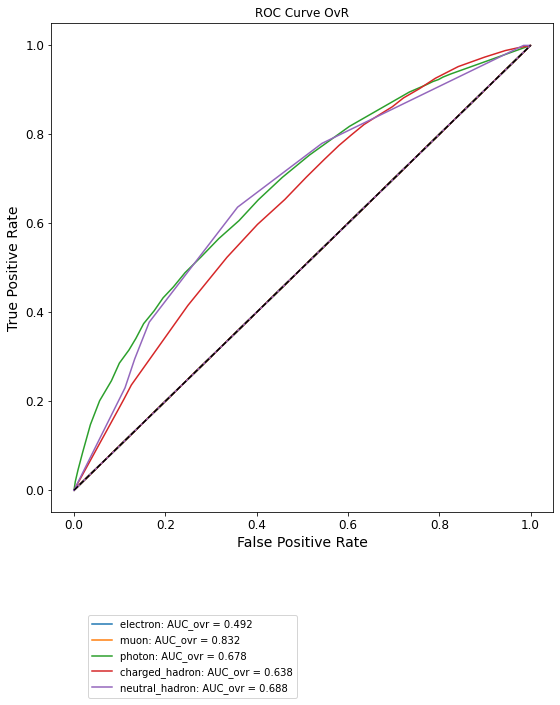

In [42]:
classes = np.array([i for i in range(5)])
roc_auc_ovr = plot_overlayed_roc_curve(classes, data.y[test_mask], out_norm[test_mask][:, classes], PDG_CLASSES, ncol=1)

0.677883350695853
0.6382801353411771


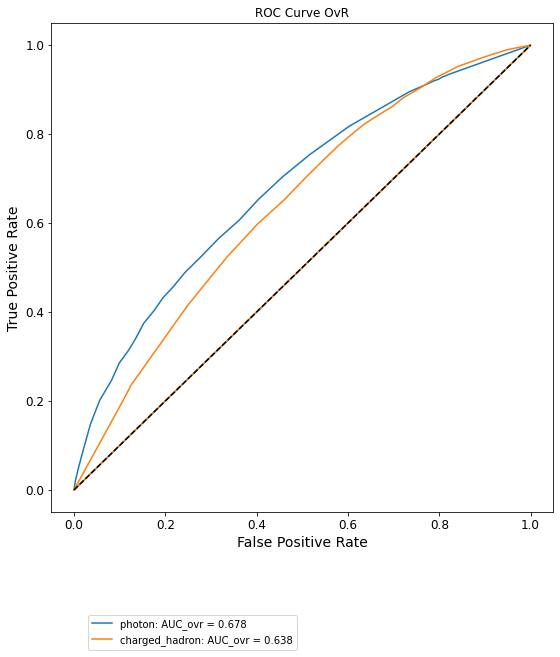

{2: 0.677883350695853, 3: 0.6382801353411771}

In [43]:
classes = [2, 3]
class_labels = ["photon", "charged_hadron"]
plot_overlayed_roc_curve(classes, data.y[test_mask], out_norm[test_mask][:, classes], class_labels, ncol=1)

In [27]:
# import seaborn as sns
# from scipy import stats
# def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
#     '''
#     Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
#     Args:
#         tpr: The list of TPRs representing each coordinate.
#         fpr: The list of FPRs representing each coordinate.
#         scatter: When True, the points used on the calculation will be plotted with the line (default = True).
#     '''
#     if ax == None:
#         plt.figure(figsize = (5, 5))
#         ax = plt.axes()
    
#     if scatter:
#         sns.scatterplot(x = fpr, y = tpr, ax = ax)
#     sns.lineplot(x = fpr, y = tpr, ax = ax)
#     sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(-0.05, 1.05)
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")

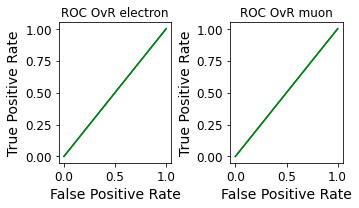

In [28]:
# # Plots the ROC Curves One vs Rest
# plt.figure(figsize = (12, 3))
# roc_auc_ovr = {}
# predictions = out_norm[test_mask]
# for i in range(len(classes)):  #for each of the classes
#     # Gets the class
#     c = classes[i]
#     y_real = [1 if y == c else 0 for y in labels_testing]
#     y_proba = predictions[:, i]
#     tpr, fpr = get_all_roc_coordinates(y_real, y_proba.cpu())
    
#     # Calculates the ROC Coordinates and plots the ROC Curves
#     ax_bottom = plt.subplot(1, 5, i+1)
#     plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
#     ax_bottom.set_title(f"ROC OvR {PDG_CLASSES[i]}")
    
#     # Calculates the ROC AUC OvR
#     roc_auc_ovr[c] = roc_auc_score(y_real, y_proba.detach().cpu())
    
# plt.tight_layout()

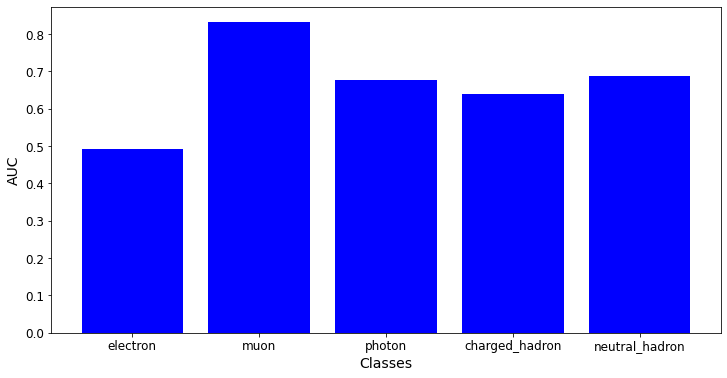

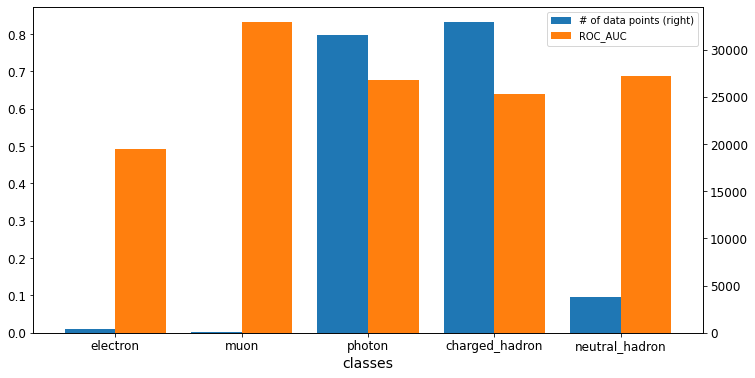

In [44]:
plot_class_balance_and_AUC(class_dict, roc_auc_ovr, PDG_CLASSES)